<a href="https://colab.research.google.com/github/lephuocdat2000/Advanced-CV/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install tf2_yolov4

     |████████████████████████████████| 686kB 11.2MB/s 


In [3]:
import tensorflow as tf
#from tensorflow.python.keras.engine import training
from tf2_yolov4.anchors import YOLOV4_ANCHORS
from tf2_yolov4.model import YOLOv4
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
import cv2
import timeit
import itertools 

distance_minimum = 60
WIDTH,HEIGHT=(1024,768)
model = YOLOv4(
        input_shape=(HEIGHT,WIDTH,3),
        anchors= YOLOV4_ANCHORS,
        num_classes=80,
        training=False,
        yolo_max_boxes=50,
        yolo_iou_threshold=0.5,
        yolo_score_threshold=0.5,    
)
CLASSES = [ 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck',
     'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench',
     'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
     'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
     'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
     'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork',
     'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli',
     'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant',
     'bed', 'dining table', 'toilet', 'tv', 'laptop',  'mouse', 'remote', 'keyboard',
     'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book',
     'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
model.load_weights('/content/drive/MyDrive/Pretrained/yolov4.h5')



In [10]:
def images_processing(model,image):
    image=tf.convert_to_tensor(image,dtype=tf.float32)
    #image = tf.io.decode_image(image)   #convert input -> tensor
    #image = tf.image.resize(image,(HEIGHT,WIDTH)) 
    images = tf.expand_dims(image,axis=0) / 255 # shape=(batch,(image.shape)) 
    boxes, scores, classes, detections = model.predict(images)
    human_index = np.where(classes[0]==0)
    boxes = np.array(itemgetter(*human_index)(boxes[0]))* [WIDTH, HEIGHT, WIDTH, HEIGHT]
    scores = np.array(itemgetter(*human_index)(scores[0]))
    classes = np.array(itemgetter(*human_index)(classes[0])).astype(int)       
    return images*255,boxes,detections
def DrawnRectangel(boxes,image,point,color):
    xmin,ymin,xmax,ymax = int(boxes[point][0]),int(boxes[point][1]),int(boxes[point][2]),int(boxes[point][3])
    cv2.rectangle(image,(int(xmin),int(ymin)),(int(xmax),int(ymax)),color,2)  
   
def video_processing(model,video_path):
    cap = cv2.VideoCapture(video_path)
    if (cap.isOpened()==False): 
        print('Error opening video stream or file')
    else: 
      fourcc = cv2.VideoWriter_fourcc(*'XVID')
      out = cv2.VideoWriter('output.avi',fourcc, 24, (1024,768))
      while (True):
          ret, frame = cap.read()
          if ret==True:
            frame = cv2.resize(frame,(1024,768))
            images,boxes,detections = images_processing(model,frame)  
            boxes= boxes[~np.all(boxes== 0, axis=1)]    
            transformed_points = Points_Transformation(boxes)
            if len(boxes) > 1:
                image_rect = frame.copy()
                list_indexes = list(itertools.combinations(range(len(transformed_points)), 2))
                x_y_ = []
                # for i,pair in enumerate(itertools.combinations(transformed_points, r=2)):
                #     if np.sqrt( (pair[0][0] - pair[1][0])**2 + (pair[0][1] - pair[1][1])**2 ) < int(distance_minimum):
                #     #change color top view
                #          index_pt1 = list_indexes[i][0]
                #          index_pt2 = list_indexes[i][1]
                #     #change color original frame
                #          DrawnRectangel(boxes,image_rect,index_pt1,(0,0,255))
                #          DrawnRectangel(boxes,image_rect,index_pt2,(0,0,255))
                #          x_y_.append(index_pt1)
                #          x_y_.append(index_pt2)

                for i in range(0,len(transformed_points)):
                      sub_vec = transformed_points[i] - transformed_points[i+1:]
                      distance = np.sqrt(sub_vec[:,0]**2+sub_vec[:,1]**2)
                      selected_points = np.array(np.where(distance<distance_minimum))[0]
                      if (len(selected_points)>0):
                          for j in selected_points:
                              DrawnRectangel(boxes,image_rect,i+j+1,(0,0,255))
                              x_y_.append(i+j+1)
                          DrawnRectangel(boxes,image_rect,i,(0,0,255))
                          x_y_.append(i)
                diff = np.setdiff1d(list(range(0,len(boxes))),np.unique(x_y_))
                for i in diff: DrawnRectangel(boxes,image_rect,i,(0,255,0))
                out.write(image_rect)
            elif len(boxes)==1: 
                 image_rect = frame.copy()
                 DrawnRectangel(boxes,image_rect,0,(0,255,0))
                 out.write(image_rect)
            else: out.write(frame)
            if cv2.waitKey(1)==ord('q'): break
          else: break 
    out.release()
    return
def show_webcam(mirror=False):
    vid = cv2.VideoCapture(0)
    while True:
       ret,frame = vid.read()
       plt.imshow('frame',frame)
       if cv2.waitKey(1) & 0xFF == ord('q'):
          break
    vid.release()
    cv2.destroyAllWindows() 
def MatrixCreation(A,B,C,D):
    width = int(max(np.sqrt((B[1]-A[1])**2+(B[0]-A[0])**2),np.sqrt((D[1]-C[1])**2+(D[0]-C[0])**2)))
    height = int(max(np.sqrt((C[1]-A[1])**2+(C[0]-A[0])**2),np.sqrt((D[1]-B[1])**2+(D[0]-B[0])**2)))
    inputs = np.float32([A,B,C,D])
    outputs = np.float32([[0,0],
                      [width-1,0],
                      [0,height-1],
                      [width-1,height-1]])
    M = cv2.getPerspectiveTransform(inputs,outputs)
    return M
def Points_Transformation(boxes):
    x_ = boxes[:,0]+(boxes[:,2]-boxes[:,0]) / 2
    # y_ = boxes[:,1]+(boxes[:,3]-boxes[:,1]) / 2
    y_ = boxes[:,3]
    x_ = np.expand_dims(x_,axis = 1)
    y_ = np.expand_dims(y_,axis = 1) 
    centroids = np.uint32(np.concatenate((x_,y_),axis=1))
    list_point_to_detect = np.float32(centroids).reshape(-1,1,2)
    transformed_points = cv2.perspectiveTransform(list_point_to_detect, M)
    transformed_points = transformed_points.reshape(transformed_points.shape[0],transformed_points.shape[2])
    return transformed_points

In [6]:
image_path= '/content/2019_05_13_72171_1557749850._large.jpg'
#image=cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2RGB)
video_path='/content/drive/MyDrive/Advanced-CV/People2_Trim.mp4'
## Get transformation matrix
A = [300,150]
B = [820,150]
C = [10,450]
D = [900,450]
M = MatrixCreation(A,B,C,D)

In [12]:
video_processing(model,video_path)

5 6


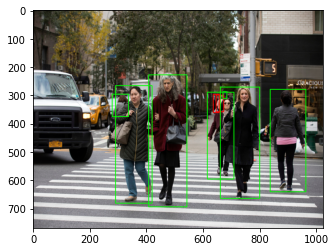

In [ ]:
image=cv2.imread('/content/drive/MyDrive/Advanced-CV/00pedxing01-superJumbo.jpg')
image = cv2.resize(image,(1024,768))
A = [300,490]
B = [900,520]
C = [0,800]
D = [1000,800]
M = MatrixCreation(A,B,C,D)
images,boxes,detections=images_processing(model,image) 
boxes= boxes[~np.all(boxes== 0, axis=1)]    
transformed_points = Points_Transformation(boxes)
if len(boxes>1):
   list_indexes = list(itertools.combinations(range(len(transformed_points)), 2))
   x_y_ = []
   for i,pair in enumerate(itertools.combinations(transformed_points, r=2)):
      if np.sqrt( (pair[0][0] - pair[1][0])**2 + (pair[0][1] - pair[1][1])**2 ) < int(distance_minimum):
            #change color top view
            index_pt1 = list_indexes[i][0]
            index_pt2 = list_indexes[i][1]
            print(index_pt1,index_pt2)
            #change color original frame
            DrawnRectangel(boxes,image,index_pt1,(0,0,255))
            DrawnRectangel(boxes,image,index_pt2,(0,0,255))
            x_y_.append(index_pt1)
            x_y_.append(index_pt2)
   x_y_ = np.unique(x_y_)
   diff = np.setdiff1d(list(range(0,len(boxes))),np.unique(x_y_))
   for i in diff: DrawnRectangel(boxes,image,i,(0,255,0))
else:
   DrawnRectangel(boxes,image,0,(0,255,0))
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

4 points image

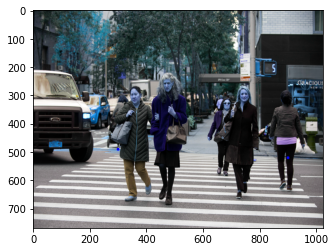

In [ ]:
image = cv2.imread('/content/drive/MyDrive/Advanced-CV/00pedxing01-superJumbo.jpg')
image = cv2.resize(image,(1024,768))
cv2.circle(image,(300,490),5,(0,0,255),-1)
cv2.circle(image,(900,520),5,(0,0,255),-1)
cv2.circle(image,(0,800),5,(0,0,255),-1)
cv2.circle(image,(1000,800),5,(0,0,255),-1)
plt.imshow(image)

4 points video

In [7]:
cap = cv2.VideoCapture('/content/drive/MyDrive/Advanced-CV/People2_Trim.mp4')
if (cap.isOpened()==False):
    print('Error opening video stream or file')
else: 
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output.avi',fourcc, 24, (1024,768))
    while (True):
       ret, frame = cap.read()
       if ret==True:
           frame = cv2.resize(frame,(1024,768))
           images,boxes,detections = images_processing(model,frame)  
           boxes= boxes[~np.all(boxes== 0, axis=1)] 
          #  cv2.circle(frame,(220,220),10,(0,0,255),-1)
          #  cv2.circle(frame,(820,220),10,(0,0,255),-1)
          #  cv2.circle(frame,(10,450),10,(0,0,255),-1)
          #  cv2.circle(frame,(900,450),10,(0,0,255),-1)
          #  plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
          #  break
           if cv2.waitKey(1)==ord('q'): break
           out.write(frame)
       else: break
    out.release()

In [ ]:
a = np.random.randn(5,2)
b = np.random.rand(1,2)

In [ ]:
print(a,b)

[[ 0.11388704 -0.86312159]
 [-0.45457889  0.65014104]
 [-1.4948105   0.57358094]
 [ 0.85725418 -0.82229675]
 [ 0.13503215 -0.25277984]] [[0.15206897 0.79227967]]


In [ ]:
c = a[0] - a[1:]

In [ ]:
c = c[:,0]**2 + c[:,1]**2

In [ ]:
c = np.sqrt(c)